# Project

## Importing modules

In [34]:
!pip install torchinfo --quiet

In [35]:
import os
import random
import gzip
import pickle
import zipfile
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
from torchinfo import summary
from matplotlib import pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Setting seed

In [36]:
# Set the seed for PyTorch
torch.manual_seed(1405)

# Set the seed for NumPy
np.random.seed(1405)

# Set the seed for Python's built-in random library
random.seed(1405)

# If using CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(1405)
    torch.cuda.manual_seed_all(1405)  # if you are using multi-GPU.

# Generic functions

The functions and classes here are taken from lab 5 with all the junk removed. They (should) work for any dataset.

In [37]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [38]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [39]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [40]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()  # ChatGPT says opt.zero_grad should be first not last?
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [41]:
def accuracy(scores, yb):
    score2prob = nn.Softmax(dim=1)
    preds = torch.argmax(score2prob(scores), dim=1)
    return (preds == yb).float().mean()

In [42]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0.0, 0
        total_samples = 0

        # Training loop
        for xb, yb in train_dl:
            # Move input data to the same device as the model
            xb = xb.to(device)
            yb = yb.to(device)

            # Unpack the loss and other outputs
            loss, _ = loss_batch(model, loss_func, xb, yb, opt)
            total_loss += loss
            preds = model(xb).argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total_samples += yb.size(0)

        # Calculate average training loss and accuracy
        train_loss = total_loss / len(train_dl)
        train_acc = total_correct / total_samples

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_loss_total, val_correct = 0.0, 0
            val_samples = 0
            for xb, yb in valid_dl:
                # Move input data to the same device as the model
                xb = xb.to(device)
                yb = yb.to(device)

                # Get validation loss
                val_loss, _ = loss_batch(model, loss_func, xb, yb)

                val_loss_total += val_loss
                preds = model(xb).argmax(dim=1)
                val_correct += (preds == yb).sum().item()
                val_samples += yb.size(0)

            val_loss_avg = val_loss_total / len(valid_dl)
            val_acc = val_correct / val_samples

        # Store metrics for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.4f}")

    # Plotting loss function
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss', marker='o')
    plt.title('Loss Function')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy', marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [43]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

Function that loads model if it exists otherwise trains

In [44]:
def load_or_train_model(model_path, epochs, model, loss_func, opt, train_dl, val_dl):
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    try:
        # Load the pre-trained model
        model.load_state_dict(torch.load(model_path))
        model.to(device)
        print(f"Model loaded from {model_path}")
    except FileNotFoundError:
        # Train the model if no saved model exists
        print(f"Model not found at {model_path}, starting training.")
        fit(epochs, model, loss_func, opt, train_dl, val_dl)
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to {model_path}")

## Loading MNIST as example

In [45]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://figshare.com/ndownloader/files/25635053"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL).content
        (PATH / FILENAME).open("wb").write(content)

In [46]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

('x_train.shape', (50000, 784))
('y_train.shape', (50000,))


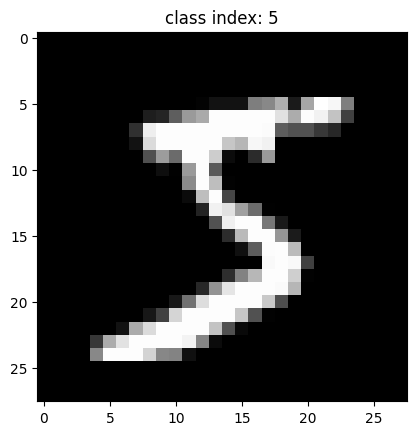

In [47]:
print(('x_train.shape',x_train.shape))
print(('y_train.shape',y_train.shape))

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
plt.title('class index: ' + str(y_train[0]));

### Split data

DataLoader is used to efficiently iterate over the datasets during training. bs is the batch size, set to 64, dictating how many samples are processed at a time.

In [48]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

bs = 64  # batch size
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

Preprocess the data to have shape (-1,1,28,28).

WrappedDataLoader applies the preprocess function to each batch of data.

In [49]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs) #forstår ikke denne. Vi har jo lige defineret train_dl og valid_dl??
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

### Model

Basic model with batchnormalization (as recommended in Training Convolutional Neural Networks - part 2)

In [50]:
MNIST_model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),  # batch normalization here
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),  # batch normalization here
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(10),  # batch normalization here
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

### Train

In [51]:
MNIST_model.to(dev) #Makes device GPU if availbale else it is CPU
lr = 0.01
epochs = 2
loss_func = F.cross_entropy
opt = optim.SGD(MNIST_model.parameters(), lr=lr, momentum=0.9)

Epoch 1/2 - Train Loss: 1.0956, Train Acc: 0.7587 - Val Loss: 0.5735, Val Acc: 0.8777
Epoch 2/2 - Train Loss: 0.4969, Train Acc: 0.9034 - Val Loss: 0.3663, Val Acc: 0.9199


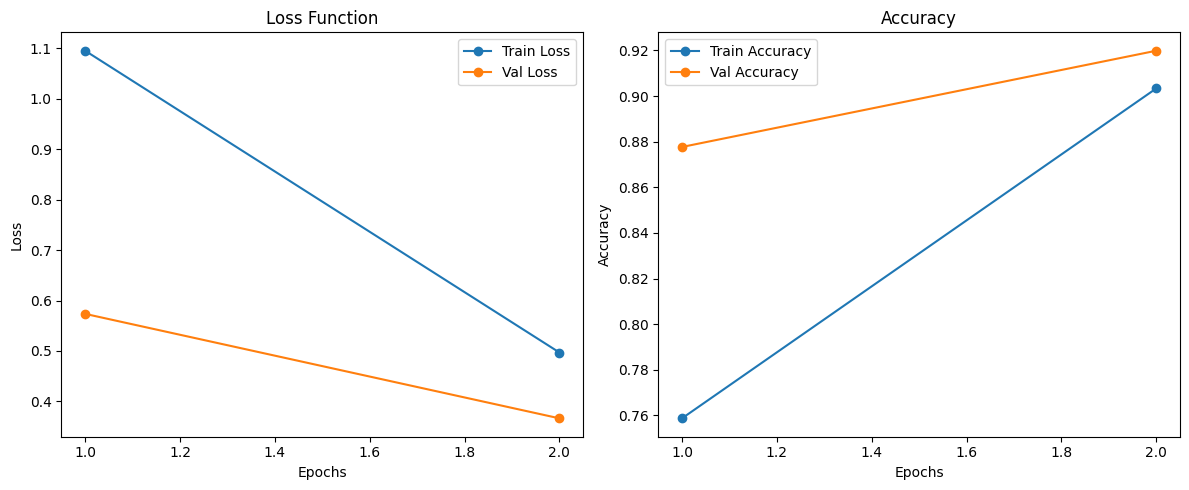

In [52]:
fit(epochs, MNIST_model, loss_func, opt, train_dl, valid_dl)

# Loading German traffic signs

In [114]:
# Path to your ZIP file in Google Drive
zip_file_path = '/content/gdrive/MyDrive/German-traffic-signs/archive.zip'

# Create a directory to extract the contents if it doesn't exist
extract_path = '/content/gtsrb'
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check the contents of the extracted folder
extracted_files = os.listdir(extract_path)
print(extracted_files)

['Test.csv', 'Train.csv', 'test', 'Test', 'Meta', 'train', 'Train', 'Meta.csv', 'meta']


**Define transformation and load into train, test and valdiadation set.**

Note that the test files the classes are hidden. So we just take train files and randomly split into train, test and validation set. Can be confirmed by running this code



```
# Check the contents of the train and test folders
train_files = os.listdir('/content/gtsrb/train')
test_files = os.listdir('/content/gtsrb/test')
print("Train folders:", train_files)
print("Test folders:", test_files)
```



In [115]:
# Define transformations for the data
transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Resize images
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalize
])

# Load the dataset and transform
full_dataset = datasets.ImageFolder(
    root='/content/gtsrb/train',
    transform=transform
)

# Check the total number of samples in the dataset
total_samples = len(full_dataset)
print(f"Total samples in the dataset: {total_samples}")

# Get the first image and its label from the dataset
image, label = full_dataset[0]

# Check the shape of the image tensor
print(f"Shape of the first image: {image.shape}")
print(f"Label of the first image: {label}")

Total samples in the dataset: 39209
Shape of the first image: torch.Size([3, 160, 160])
Label of the first image: 0


Now we split this into 70% train, 15% validation and 15% test.

In [116]:
# Define the split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the lengths for each split
train_size = int(train_ratio * total_samples)
val_size = int(val_ratio * total_samples)
test_size = total_samples - train_size - val_size

print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

Train size: 27446, Validation size: 5881, Test size: 5882


In [117]:
# Randomly split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

In [118]:
# Set the batch size
bs = 64

# Create DataLoaders. A dataloader provides an efficient way to iterate over your dataset during training
train_dl = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=bs * 2, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=bs * 2, shuffle=False)

## Dataset summary

Show how many classes we have in dataset:

In [119]:
# Get the number of classes from the original dataset (full_dataset)
num_classes = len(full_dataset.classes)

# Print the number of classes
print(f"Number of classes in the dataset: {num_classes}")

Number of classes in the dataset: 43


43 classes

## Visualize the classes

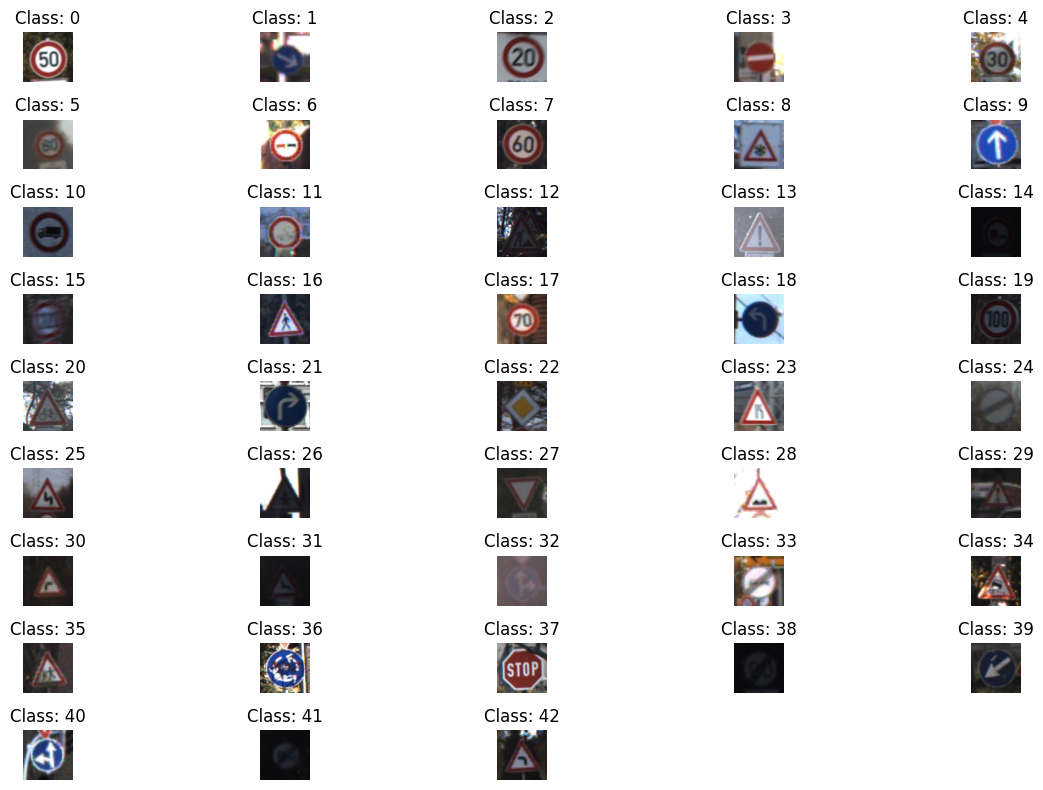

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# Function to show images
def imshow(img):
    # Unnormalize the image
    img = img / 2 + 0.5  # Undo normalization
    img = img.numpy()  # Convert to numpy array
    plt.imshow(np.transpose(img, (1, 2, 0)))  # Convert to HWC format
    plt.axis('off')  # Hide axis

# Create a dictionary to keep track of images displayed for each class
class_count = {i: 0 for i in range(num_classes)}

# Store images and labels
ordered_images = []
ordered_labels = []

# Get images until one for each class is found
while len(ordered_images) < num_classes:
    dataiter = iter(train_dl)  # Reset the iterator for each pass
    images, labels = next(dataiter)

    # Loop through the images to find and store one per class
    for i in range(len(images)):
        label = labels[i].item()

        # Check if we have already stored an image for this class
        if class_count[label] < 1:  # Change to images_per_class if needed
            ordered_images.append(images[i])  # Store the image
            ordered_labels.append(label)  # Store the label
            class_count[label] += 1  # Increment count for this class

# Plot the images and their corresponding labels in order
ordered_labels = np.sort(ordered_labels)
plt.figure(figsize=(12, 8))
num_images_per_row = 5  # Maximum images per row

# Loop to display images in order
for i, (img, label) in enumerate(zip(ordered_images, ordered_labels)):
    plt.subplot((num_classes + num_images_per_row - 1) // num_images_per_row, num_images_per_row, i + 1)
    imshow(img)
    plt.title(f'Class: {label}')

plt.tight_layout()
plt.show()

## Baseline model

In [60]:
baseline_model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),  # Flattening the tensor
    nn.Linear(64, num_classes),
)



```
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),#Used to flatten he output
    #nn.Flatten(), # Flatten the output for the linear layer
    nn.Linear(64, 43), # Linear layer to produce 35 outputs (logits)
)
```



In [61]:
summary(baseline_model, input_size=(1, 3, 160, 160))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 43]                   --
├─Conv2d: 1-1                            [1, 16, 80, 80]           448
├─ReLU: 1-2                              [1, 16, 80, 80]           --
├─Conv2d: 1-3                            [1, 32, 40, 40]           4,640
├─ReLU: 1-4                              [1, 32, 40, 40]           --
├─Conv2d: 1-5                            [1, 64, 20, 20]           18,496
├─ReLU: 1-6                              [1, 64, 20, 20]           --
├─AdaptiveAvgPool2d: 1-7                 [1, 64, 1, 1]             --
├─Lambda: 1-8                            [1, 64]                   --
├─Linear: 1-9                            [1, 43]                   2,795
Total params: 26,379
Trainable params: 26,379
Non-trainable params: 0
Total mult-adds (M): 17.69
Input size (MB): 0.31
Forward/backward pass size (MB): 1.43
Params size (MB): 0.11
Estimated Total Size (MB): 1.85

### Train baseline model

In [62]:
baseline_model.to(dev)
lr = 0.01
epochs = 15
loss_func = F.cross_entropy
opt = torch.optim.SGD(baseline_model.parameters(), lr=lr)
# opt = torch.optim.Adam(baseline_model.parameters(), lr=lr) # Adam optimizer

The output is the loss.

<ipython-input-44-9206ab618b84>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model not found at /content/gdrive/MyDrive/German-traffic-signs/baseline_model.pth, starting training.
Epoch 1/1 - Train Loss: 3.6953, Train Acc: 0.0470 - Val Loss: 3.5488, Val Acc: 0.0505


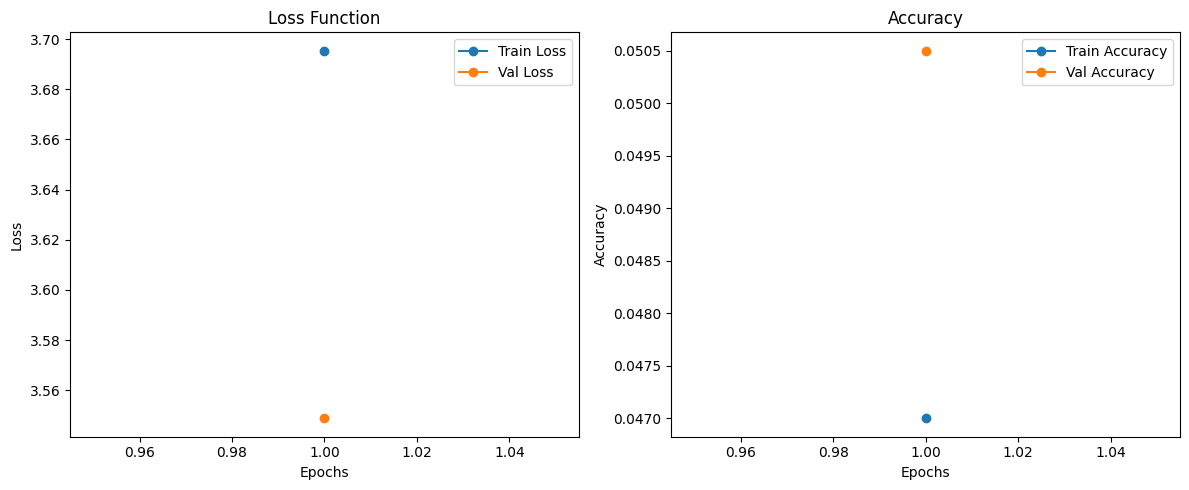

Model saved to /content/gdrive/MyDrive/German-traffic-signs/baseline_model.pth


In [63]:
path_model ='/content/gdrive/MyDrive/German-traffic-signs/baseline_model.pth'
load_or_train_model(path_model, epochs, baseline_model, loss_func, opt, train_dl, val_dl)

In [64]:
#fit(epochs, baseline_model, loss_func, opt, train_dl, val_dl)

Try some more epochs

In [65]:
#fit(epochs, baseline_model, loss_func, opt, train_dl, val_dl)

It is very slow to find the minimum, therefore i will try with momentum

In [66]:
baseline_model1 = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),  # Flattening the tensor
    nn.Linear(64, num_classes),
)

In [67]:
baseline_model1.to(dev)
lr = 0.01
epochs = 15
loss_func = F.cross_entropy
opt = torch.optim.SGD(baseline_model1.parameters(), lr=lr, momentum=0.9)

In [68]:
# fit(epochs, baseline_model1, loss_func, opt, train_dl, val_dl)

Model not found at /content/gdrive/MyDrive/German-traffic-signs/baseline_model1.pth, starting training.


<ipython-input-44-9206ab618b84>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Epoch 1/1 - Train Loss: 3.4663, Train Acc: 0.0743 - Val Loss: 3.3906, Val Acc: 0.0877


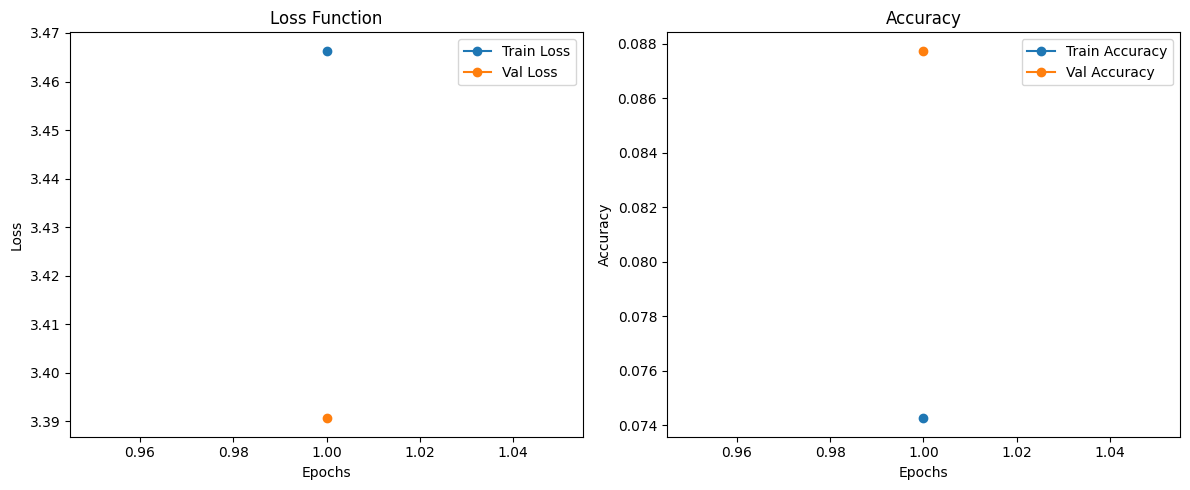

Model saved to /content/gdrive/MyDrive/German-traffic-signs/baseline_model1.pth


In [69]:
path_model ='/content/gdrive/MyDrive/German-traffic-signs/baseline_model1.pth'
load_or_train_model(path_model, epochs, baseline_model1, loss_func, opt, train_dl, val_dl)

Try more epochs

In [70]:
baseline_model1.to(dev)
lr = 0.01
epochs = 5
loss_func = F.cross_entropy
opt = torch.optim.SGD(baseline_model1.parameters(), lr=lr, momentum=0.9)

In [71]:
# fit(epochs, baseline_model1, loss_func, opt, train_dl, val_dl)

Skal have kommenteret herpå. Stadig lidt langsom til at finde mimum.

Langsom til minimum.
Løsninger:
* Bruge anden optimizer såsom adam
* Kan ændre lr. Kan bruge step decay

Prøver med adam optimizer

In [72]:
baseline_model2 = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),  # Flattening the tensor
    nn.Linear(64, num_classes),
)

In [73]:
baseline_model2.to(dev)
lr = 0.05 #måske skifte denne ti 0.01 igen
epochs = 10
loss_func = F.cross_entropy
opt = torch.optim.Adam(baseline_model2.parameters(), lr=lr)

In [74]:
# fit(epochs, baseline_model2, loss_func, opt, train_dl, val_dl)

Model not found at /content/gdrive/MyDrive/German-traffic-signs/baseline_model2.pth, starting training.


<ipython-input-44-9206ab618b84>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Epoch 1/1 - Train Loss: 3.5683, Train Acc: 0.0564 - Val Loss: 3.5022, Val Acc: 0.0559


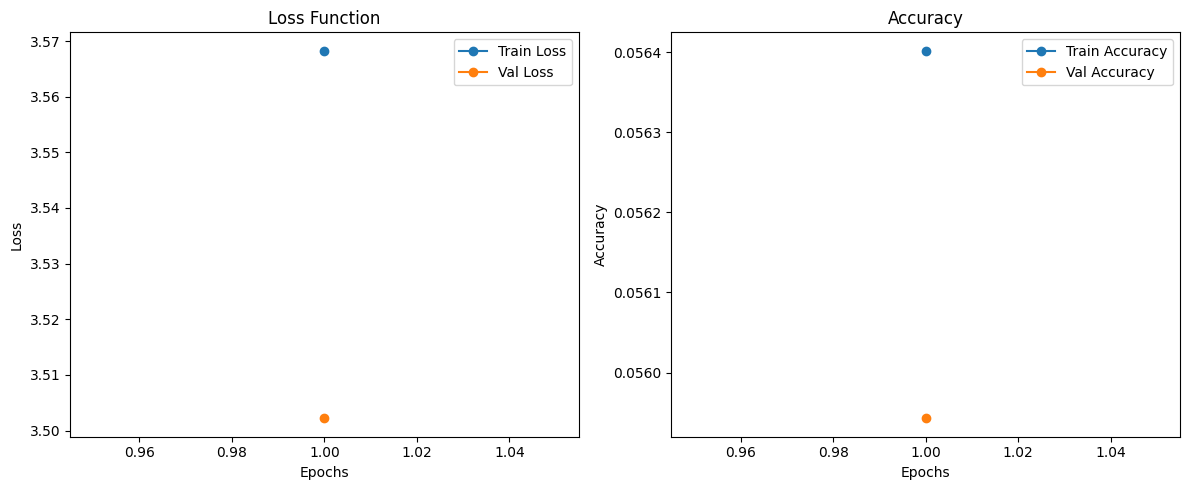

Model saved to /content/gdrive/MyDrive/German-traffic-signs/baseline_model2.pth


In [75]:
path_model ='/content/gdrive/MyDrive/German-traffic-signs/baseline_model2.pth'
load_or_train_model(path_model, epochs, baseline_model2, loss_func, opt, train_dl, val_dl)

Ved adam virker det til at jeg får noget vanishing geradient. Prøver batch normalization



Prøver batch normalization herunder uden adam, da dette gjorde den dårligere



In [76]:
model_batchnorm = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),  # Flattening the tensor
    nn.Linear(64, num_classes),
)

In [77]:
model_batchnorm.to(dev)
lr = 0.05
epochs = 20
loss_func = F.cross_entropy
opt = torch.optim.SGD(model_batchnorm.parameters(), lr=lr, momentum=0.9)

In [78]:
# fit(epochs, model_batchnorm, loss_func, opt, train_dl, val_dl)

Try to add adam optimizer. Maybe reason that it is still slow

Why use ADAM: Impact on Traffic Sign Recognition: The dataset likely has a complex loss landscape. Adam helps navigate this efficiently by adjusting learning rates for different parameters, potentially leading to quicker training.

In [79]:
model_adam = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),  # Flattening the tensor
    nn.Linear(64, num_classes),
)

In [80]:
model_adam.to(dev)
lr = 0.05
epochs = 20
loss_func = F.cross_entropy
opt = torch.optim.Adam(model_adam.parameters(), lr=lr)

In [81]:
# fit(epochs, model_adam, loss_func, opt, train_dl, val_dl)

Model not found at /content/gdrive/MyDrive/German-traffic-signs/model_adam.pth, starting training.


<ipython-input-44-9206ab618b84>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Epoch 1/1 - Train Loss: 2.9011, Train Acc: 0.1913 - Val Loss: 2.9607, Val Acc: 0.1808


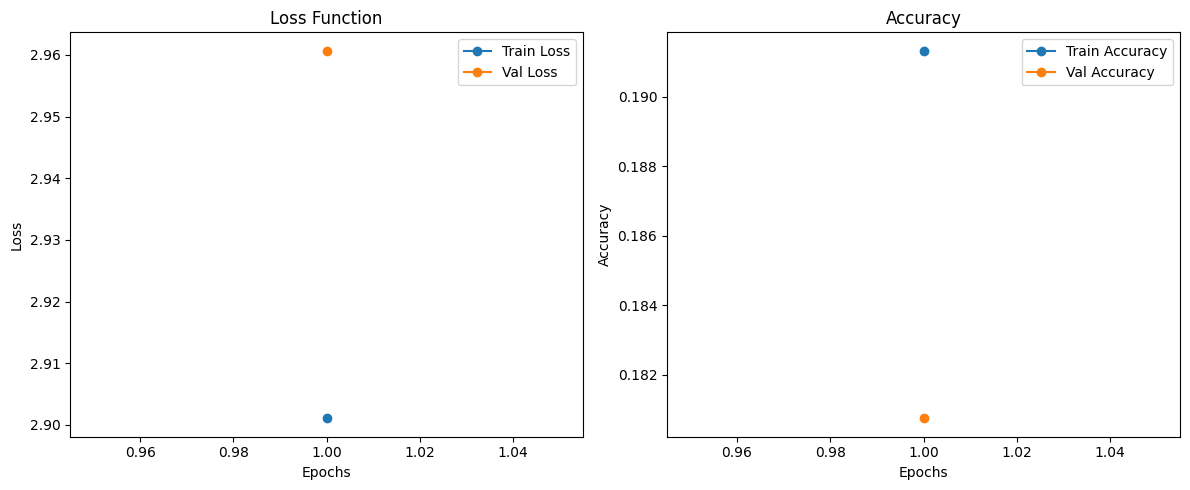

Model saved to /content/gdrive/MyDrive/German-traffic-signs/model_adam.pth


In [82]:
path_model ='/content/gdrive/MyDrive/German-traffic-signs/model_adam.pth'
load_or_train_model(path_model, epochs, model_adam, loss_func, opt, train_dl, val_dl)

Now it seems like it is startung to overfit a bit on the training data (not much?), will therefore try using dropout. Maybe i will also add one more layer.

In [83]:
model_dropout = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),  # Flattening the tensor
    nn.Dropout(0.3), # Dropout applied here for the dense layer
    nn.Linear(128, num_classes),
)

In [84]:
model_dropout.to(dev)
lr = 0.05
epochs = 20
loss_func = F.cross_entropy
opt = torch.optim.Adam(model_dropout.parameters(), lr=lr)

Model not found at /content/gdrive/MyDrive/German-traffic-signs/model_dropout.pth, starting training.


<ipython-input-44-9206ab618b84>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Epoch 1/1 - Train Loss: 3.0768, Train Acc: 0.1504 - Val Loss: 2.9340, Val Acc: 0.1697


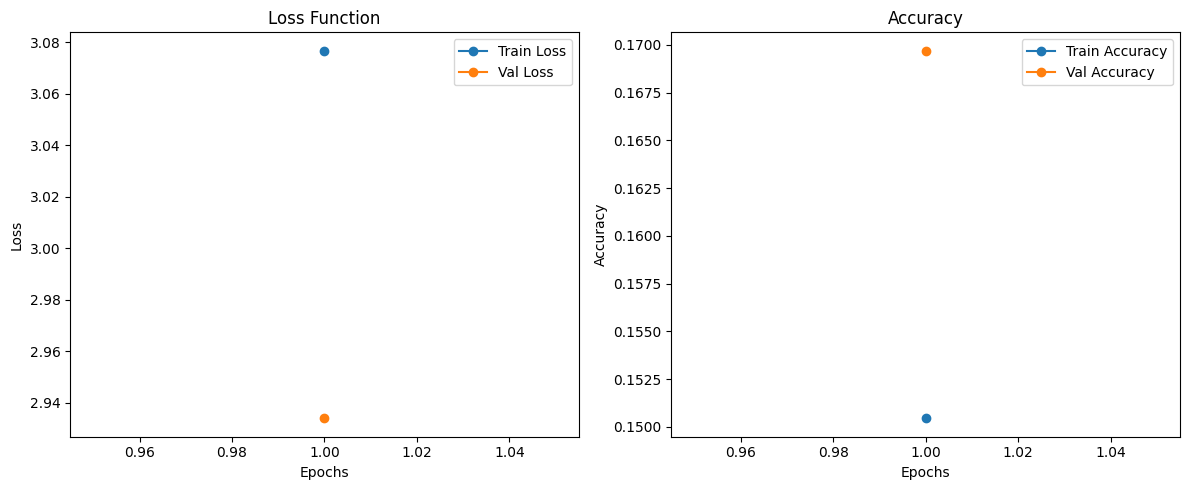

Model saved to /content/gdrive/MyDrive/German-traffic-signs/model_dropout.pth


In [85]:
path_model ='/content/gdrive/MyDrive/German-traffic-signs/model_dropout.pth'
load_or_train_model(path_model, epochs, model_dropout, loss_func, opt, train_dl, val_dl)

In [86]:
# fit(epochs, model_dropout, loss_func, opt, train_dl, val_dl)

Here we see val acc higher than train acc. This is due to the fact that we use dropotu and this is only applied during training

Would like to check if ti was dropout or the extra layer that did the most

In [87]:
model_dropout1 = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),  # Flattening the tensor
    nn.Dropout(0.3), # Dropout applied here for the dense layer
    nn.Linear(64, num_classes),
)

In [88]:
model_dropout1.to(dev)
lr = 0.05
epochs = 15
loss_func = F.cross_entropy
opt = torch.optim.Adam(model_dropout1.parameters(), lr=lr)

In [89]:
# fit(epochs, model_dropout1, loss_func, opt, train_dl, val_dl)

Model not found at /content/gdrive/MyDrive/German-traffic-signs/model_dropout1.pth, starting training.


<ipython-input-44-9206ab618b84>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Epoch 1/1 - Train Loss: 3.0820, Train Acc: 0.1507 - Val Loss: 3.7846, Val Acc: 0.1262


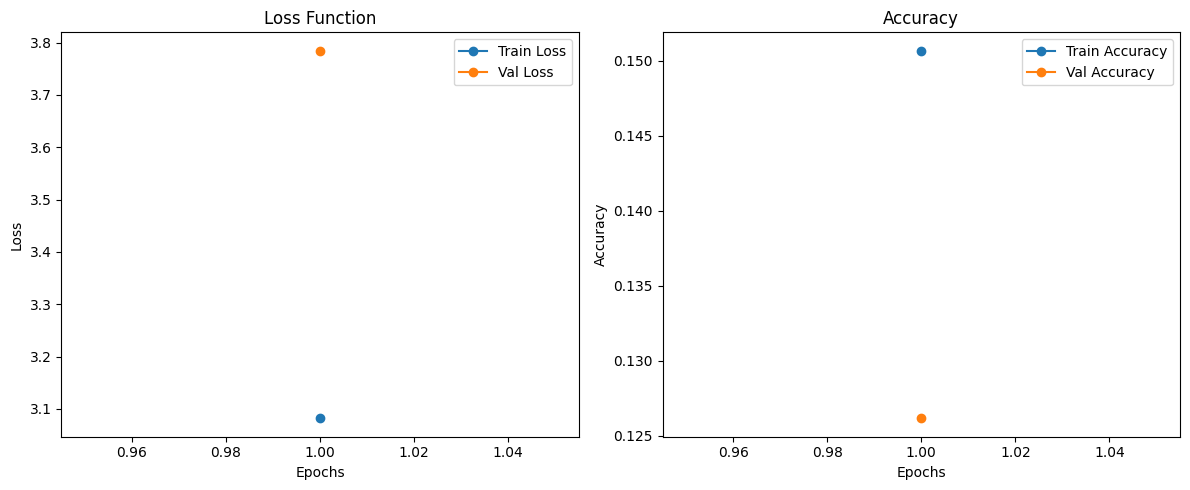

Model saved to /content/gdrive/MyDrive/German-traffic-signs/model_dropout1.pth


In [90]:
path_model ='/content/gdrive/MyDrive/German-traffic-signs/model_dropout1.pth'
load_or_train_model(path_model, epochs, model_dropout1, loss_func, opt, train_dl, val_dl)

Seems like it is mostly the extra layer

We see that it very important with the layers, so i try to add one more to see if it gets better

Try to add one more layer to see if it will get a better accuracy (maybe it is not capable of capturing the underlying patterns of the data

In [91]:
model_complex1 = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),

    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),  # Flattening the tensor
    nn.Dropout(0.3), # Dropout applied here for the dense layer
    nn.Linear(256, num_classes),
)

In [92]:
model_complex1.to(dev)
lr = 0.05
epochs = 15
loss_func = F.cross_entropy
opt = torch.optim.Adam(model_complex1.parameters(), lr=lr)

In [93]:
# fit(epochs, model_complex1, loss_func, opt, train_dl, val_dl)

Model not found at /content/gdrive/MyDrive/German-traffic-signs/model_complex1.pth, starting training.


<ipython-input-44-9206ab618b84>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Epoch 1/1 - Train Loss: 3.0817, Train Acc: 0.1516 - Val Loss: 2.5818, Val Acc: 0.2603


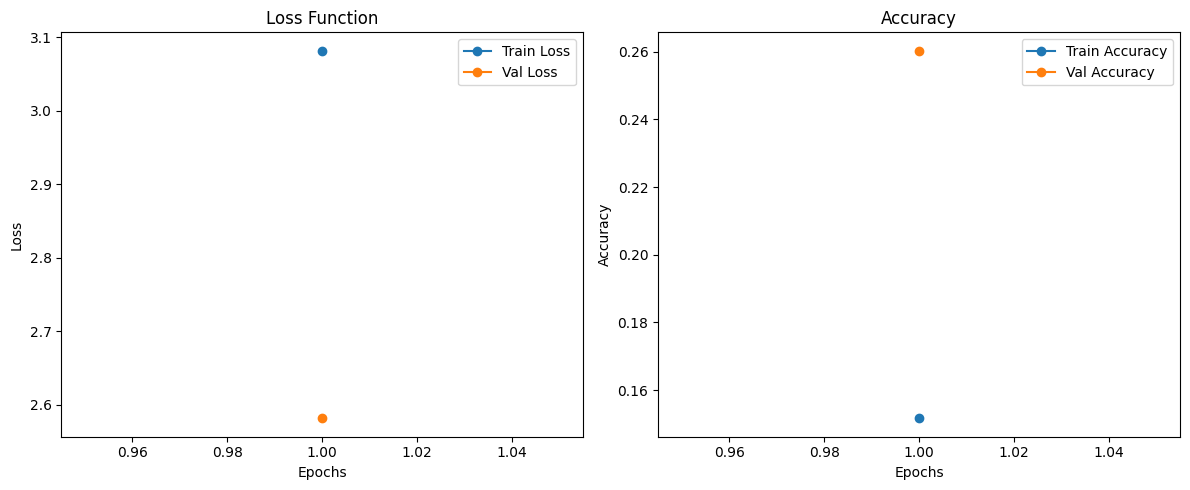

Model saved to /content/gdrive/MyDrive/German-traffic-signs/model_complex1.pth


In [94]:
path_model ='/content/gdrive/MyDrive/German-traffic-signs/model_complex1.pth'
load_or_train_model(path_model, epochs, model_complex1, loss_func, opt, train_dl, val_dl)

Consider trying to remove the dropout to see if it performs equally well without it

### Visualize some predictions

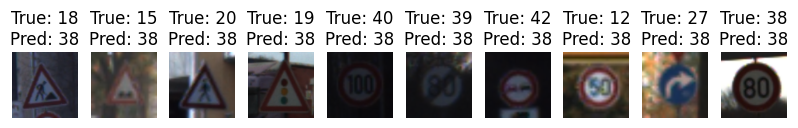

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): AdaptiveAvgPool2d(output_size=1)
  (7): Lambda()
  (8): Linear(in_features=64, out_features=43, bias=True)
)

In [95]:
def denormalize(img):
    img = img / 2 + 0.5  # assuming the images were normalized to [-1, 1]
    return img.clamp(0, 1)  # clamp values to [0, 1]

# Modified show_images function with denormalization
def show_images(images, labels, preds, num_images=10):
    images = denormalize(images)  # Denormalize before displaying
    plt.figure(figsize=(10, 10))

    # Limit to the specified number of images (default is 5)
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())  # Assuming images are in [C, H, W] format
        plt.title(f'True: {labels[i]}\nPred: {preds[i]}')
        plt.axis('off')
    plt.show()

# Get a batch of validation images
baseline_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in val_dl:  # val_dl is your validation dataloader
        images, labels = images.to(dev), labels.to(dev)  # Move to device if necessary
        outputs = baseline_model(images)  # Get model predictions
        _, preds = torch.max(outputs, 1)  # Get predicted class index

        # Show images and their predicted labels
        show_images(images.cpu(), labels.cpu(), preds.cpu())
        break  # Show only one batch of images

# Revert model back to training mode
baseline_model.train()

## Data augmentation

Consider adding some data augmentation

## Better model (batch normalization, dropout, bigger model)

In [166]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),

    Lambda(lambda x: x.view(x.size(0), -1)),  # Flattening the tensor
    nn.Linear(256, 128),  # Linear layer
    nn.ReLU(),
    nn.Dropout(0.3),  # Dropout applied here for the dense layer

    nn.Linear(128, num_classes)
)

In [97]:
summary(model, input_size=(1, 3, 160, 160))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 43]                   --
├─Conv2d: 1-1                            [1, 16, 80, 80]           448
├─BatchNorm2d: 1-2                       [1, 16, 80, 80]           32
├─ReLU: 1-3                              [1, 16, 80, 80]           --
├─Conv2d: 1-4                            [1, 32, 40, 40]           4,640
├─BatchNorm2d: 1-5                       [1, 32, 40, 40]           64
├─ReLU: 1-6                              [1, 32, 40, 40]           --
├─Conv2d: 1-7                            [1, 64, 20, 20]           18,496
├─BatchNorm2d: 1-8                       [1, 64, 20, 20]           128
├─ReLU: 1-9                              [1, 64, 20, 20]           --
├─Conv2d: 1-10                           [1, 128, 10, 10]          73,856
├─BatchNorm2d: 1-11                      [1, 128, 10, 10]          256
├─ReLU: 1-12                             [1, 128, 10, 10]          --
├



```
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),  # batch normalization here
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),  # batch normalization here
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),  # batch normalization here
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(64, 43), # Linear layer to produce 35 outputs (logits)
)
```



### Train model

In [98]:
model.to(dev)
lr = 0.01
epochs = 15
loss_func = F.cross_entropy
opt = torch.optim.Adam(model.parameters(), lr=lr) # Adam optimizer

In [99]:
path_model ='/content/gdrive/MyDrive/German-traffic-signs/model.pth'
load_or_train_model(path_model, epochs, model, loss_func, opt, train_dl, val_dl)

# fit(epochs, model, loss_func, opt, train_dl, val_dl)

Model loaded from /content/gdrive/MyDrive/German-traffic-signs/model.pth


<ipython-input-44-9206ab618b84>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Clearly not done training.... Can just continue trainning by recalling fit like this (it remembers the weights it has learned from the training above).

```
fit(epochs, model, loss_func, opt, train_dl, val_dl)
```



In [100]:
# fit(epochs, model, loss_func, opt, train_dl, val_dl)

Training 15 epochs more and lowering the lr:

In [101]:
model.to(dev)
lr = 0.005
epochs = 15
loss_func = F.cross_entropy
opt = torch.optim.Adam(model.parameters(), lr=lr) # Adam optimizer

Loaded model above, but otherwise run this maybe

In [102]:
# fit(epochs, model, loss_func, opt, train_dl, val_dl)

### Visualize some predictions

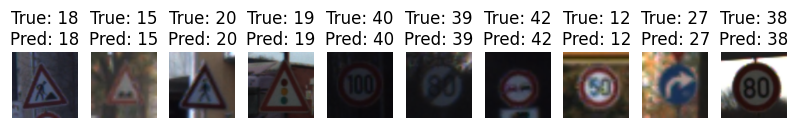

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): AdaptiveAvgPool2d(output_size=1)
  (16): Lambda()
  (17): Linear(in_features=256, out_features=128, b

In [103]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in val_dl:  # val_dl is your validation dataloader
        images, labels = images.to(dev), labels.to(dev)  # Move to device if necessary
        outputs = model(images)  # Get model predictions
        _, preds = torch.max(outputs, 1)  # Get predicted class index

        # Show images and their predicted labels
        show_images(images.cpu(), labels.cpu(), preds.cpu())
        break  # Show only one batch of images

# revert model back to train mode
model.train()

## Transfer learning

We use the ResNet50 pre-trained on ImageNet for transfer learning

In [104]:
from torchvision import models

# Load ResNet50 pre-trained on ImageNet
model_transfer = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze all layers except the final fully connected layer
for param in model_transfer.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to match the number of classes
model_transfer.fc = nn.Linear(model_transfer.fc.in_features, num_classes)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]


In [105]:
model_transfer.to(dev)
lr = 0.01
epochs = 15
loss_func = F.cross_entropy
opt = torch.optim.Adam(model_transfer.parameters(), lr=lr) # Adam optimizer

<ipython-input-44-9206ab618b84>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model not found at /content/gdrive/MyDrive/German-traffic-signs/transfer_model.pth, starting training.
Epoch 1/1 - Train Loss: 0.8937, Train Acc: 0.7891 - Val Loss: 0.5396, Val Acc: 0.8335


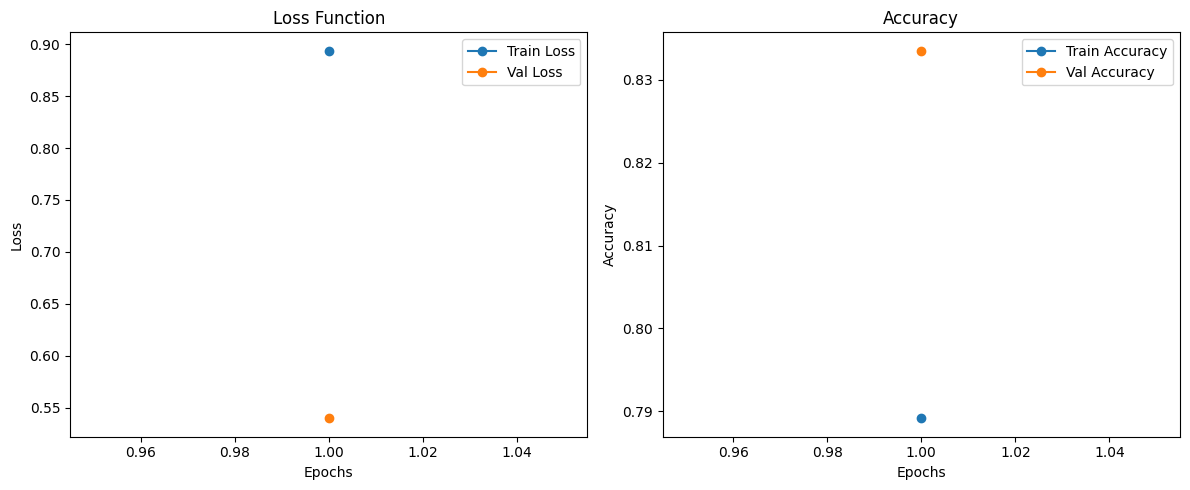

Model saved to /content/gdrive/MyDrive/German-traffic-signs/transfer_model.pth


In [106]:
transfer_model_path = '/content/gdrive/MyDrive/German-traffic-signs/transfer_model.pth'
load_or_train_model(
    transfer_model_path,
    epochs, model_transfer,
    loss_func,
    opt,
    train_dl,
    val_dl
)

# Bayesian CNN



We will now also train a bayesian CNN. We will (for now) do it by doing Bayes by Backprop (BBB)

## Bayes by Backprop (BBB)

See chapter 5 in Enhancing deep learning with bayesian inference. Code for the example is given here: https://github.com/PacktPublishing/Enhancing-Deep-Learning-with-Bayesian-Inference/tree/main/ch05/bbb

(Maybe a library already exists so less code needed?)

#### Using torchbnn

##### 1st attempt

In [ ]:
!pip install torchbnn --quiet

In [ ]:
import torchbnn as bnn

In [ ]:
class BayesianCNN(nn.Module):
    def __init__(self, num_classes):
        super(BayesianCNN, self).__init__()

        prior_mu = 0
        prior_sigma = 1
        self.conv1 = bnn.BayesConv2d(
            prior_mu, prior_sigma, 3, 16, kernel_size=3, stride=2, padding=1
        )
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = bnn.BayesConv2d(
            prior_mu, prior_sigma, 16, 32, kernel_size=3, stride=2, padding=1
        )
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = bnn.BayesConv2d(
            prior_mu, prior_sigma, 32, 64, kernel_size=3, stride=2, padding=1
        )
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = bnn.BayesConv2d(
            prior_mu, prior_sigma, 64, 128, kernel_size=3, stride=2, padding=1
        )
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = bnn.BayesConv2d(
            prior_mu, prior_sigma, 128, 256, kernel_size=3, stride=2, padding=1
        )
        self.bn5 = nn.BatchNorm2d(256)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.fc1 = bnn.BayesLinear(prior_mu, prior_sigma, 256, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = bnn.BayesLinear(prior_mu, prior_sigma, 128, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_bnn = BayesianCNN(num_classes=num_classes).to(dev)

Modifying loss_batch and fit function slightly to do bayesian neural networks.

In [ ]:
def loss_batch_bnn(model, loss_func, xb, yb, opt=None):
    # Forward pass
    preds = model(xb)
    loss = loss_func(preds, yb)

    # Add KL Divergence for Bayesian layers
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
    kl = kl_loss(model)

    # Total loss: cross-entropy + KL divergence
    total_loss = loss + 0.1 * kl  # 0.1 as the weight for KL divergence

    if opt is not None:
        total_loss.backward()
        opt.step()
        opt.zero_grad()

    return total_loss.item(), len(xb)

In [ ]:
def fit_bnn(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0.0, 0
        total_samples = 0

        # Training loop
        for xb, yb in train_dl:
            # Move input data to the same device as the model
            xb = xb.to(device)
            yb = yb.to(device)

            # Unpack the loss and other outputs
            loss, _ = loss_batch_bnn(model, loss_func, xb, yb, opt)
            total_loss += loss
            preds = model(xb).argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total_samples += yb.size(0)

        # Calculate average training loss and accuracy
        train_loss = total_loss / len(train_dl)
        train_acc = total_correct / total_samples

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_loss_total, val_correct = 0.0, 0
            val_samples = 0
            for xb, yb in valid_dl:
                # Move input data to the same device as the model
                xb = xb.to(device)
                yb = yb.to(device)

                # Get validation loss
                val_loss, _ = loss_batch_bnn(model, loss_func, xb, yb)

                val_loss_total += val_loss
                preds = model(xb).argmax(dim=1)
                val_correct += (preds == yb).sum().item()
                val_samples += yb.size(0)

            val_loss_avg = val_loss_total / len(valid_dl)
            val_acc = val_correct / val_samples

        # Store metrics for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.4f}")

    # Plotting loss and accuracy
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss', marker='o')
    plt.title('Loss Function')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy', marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
lr = 0.01
epochs = 2
loss_func = F.cross_entropy
opt = torch.optim.Adam(model.parameters(), lr=lr) # Adam optimizer

In [ ]:
fit_bnn(epochs, model_bnn, loss_func, opt, train_dl, val_dl)

In [ ]:
torch.save(model_bnn.state_dict(), '/content/gdrive/MyDrive/German-traffic-signs/model_bnn.pth')



```
# Load saved model
model_bnn.load_state_dict(torch.load('/content/gdrive/MyDrive/German-traffic-signs/model_bnn.pth'))
```



##### 2nd attempt

Essentially copied from torchbnn vignette.

In [ ]:
model_bnn_2 = nn.Sequential(
    bnn.BayesLinear(
        prior_mu=0,
        prior_sigma=0.1,
        in_features=3 * 160 * 160,
        out_features=100
    ),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=43),
)

In [ ]:
ce_loss = nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model_bnn_2.parameters(), lr=0.01)

In [ ]:
# Training loop
for step, (x, y) in enumerate(train_dl):
    x = x.view(x.size(0), -1)  # Flatten the input tensor

    pre = model_bnn_2(x)       # Forward pass
    ce = ce_loss(pre, y)       # Compute cross-entropy loss
    kl = kl_loss(model_bnn_2)  # Compute KL divergence loss
    cost = ce + kl_weight * kl  # Total cost

    optimizer.zero_grad()      # Zero out the gradients
    cost.backward()            # Backpropagate
    optimizer.step()           # Update weights

    # Calculate and print accuracy
    _, predicted = torch.max(pre.data, 1)
    total = y.size(0)
    correct = (predicted == y).sum().item()
    print(f'- Step {step}, Accuracy: {100 * correct / total:.2f} %')
    print(f'- CE Loss: {ce.item():.2f}, KL Loss: {kl.item():.2f}')

##### 3rd attempt

Same model as the non-bayesian one, but making the linear layers of our model bayesian.

In [ ]:
model_bnn = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),  # Global pooling to reduce spatial dimensions

    Lambda(lambda x: x.view(x.size(0), -1)),  # Flattening the tensor

    # Replace the deterministic Linear layers with Bayesian Linear layers
    bnn.BayesLinear(
        prior_mu=0,
        prior_sigma=0.1,
        in_features=256,
        out_features=128
    ),
    nn.ReLU(),
    nn.Dropout(0.3),

    bnn.BayesLinear(
        prior_mu=0,
        prior_sigma=0.1,
        in_features=128,
        out_features=num_classes
    )
)

Almost same function as fit, but just modifed for the bayesian setup.

In [ ]:
def fit_bnn(epochs, model, ce_loss_func, kl_loss_func, kl_weight, opt, train_dl, valid_dl):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0.0, 0
        total_samples = 0

        # Training loop
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)

            # Clear gradients
            opt.zero_grad()

            # Forward pass through the model
            preds = model(xb)

            # Cross-entropy loss
            ce_loss = ce_loss_func(preds, yb)

            # KL divergence loss
            kl_loss = kl_loss_func(model)

            # Total loss: CE loss + weighted KL loss
            total_loss_value = ce_loss + kl_weight * kl_loss

            # Backpropagation
            total_loss_value.backward()

            # Update model weights
            opt.step()

            # Accumulate loss and accuracy
            total_loss += total_loss_value.item()
            total_correct += (preds.argmax(dim=1) == yb).sum().item()
            total_samples += yb.size(0)

        # Calculate average training loss and accuracy
        train_loss = total_loss / len(train_dl)
        train_acc = total_correct / total_samples

        # Validation loop
        model.eval()
        val_loss_total, val_correct = 0.0, 0
        val_samples = 0

        with torch.no_grad():
            for xb, yb in valid_dl:
                xb = xb.to(device)
                yb = yb.to(device)

                # Forward pass
                preds = model(xb)

                # Compute validation loss
                ce_loss = ce_loss_func(preds, yb)
                kl_loss = kl_loss_func(model)
                total_loss_value = ce_loss + kl_weight * kl_loss

                val_loss_total += total_loss_value.item()
                val_correct += (preds.argmax(dim=1) == yb).sum().item()
                val_samples += yb.size(0)

        # Calculate average validation loss and accuracy
        val_loss_avg = val_loss_total / len(valid_dl)
        val_acc = val_correct / val_samples

        # Store metrics for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.4f}")

    # Plotting loss and accuracy over epochs
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss', marker='o')
    plt.title('Loss Function')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy', marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Cross-entropy loss
ce_loss_func = nn.CrossEntropyLoss()

# KL divergence loss for Bayesian layers
kl_loss_func = bnn.BKLLoss(reduction='mean', last_layer_only=False)

# Optimizer
opt = optim.Adam(model_bnn.parameters(), lr=0.01)

# Train the Bayesian CNN
fit_bnn(epochs=10, model=model_bnn, ce_loss_func=ce_loss_func, kl_loss_func=kl_loss_func,
        kl_weight=0.01, opt=opt, train_dl=train_dl, valid_dl=val_dl)

In [ ]:
torch.save(model_bnn.state_dict(), '/content/gdrive/MyDrive/German-traffic-signs/model_bnn.pth')

###### Prediction/inference

In [ ]:
def sample_and_predict(model, image, num_samples=10):
    predictions = []

    for _ in range(num_samples):
        # Sample from the posterior weights
        with torch.no_grad():
            pred = model(image)  # Forward pass to get the prediction
            predictions.append(pred)

    # Convert predictions to a tensor for easier processing
    predictions = torch.stack(predictions)

    # Get the class predictions by taking the mode across the samples
    preds_classes = predictions.argmax(dim=2).mode(dim=0).values

    # Get probabilities of each class for the last layer
    probabilities = torch.softmax(predictions, dim=2)

    return preds_classes, probabilities

# Modified function to visualize predictions with sampling
def show_random_predictions(model, valid_dl, num_samples=10):
    model.eval()  # Set the model to evaluation mode

    # Get a random batch from the validation data loader
    for xb, yb in valid_dl:
        # Randomly select an index from the batch
        random_index = random.randint(0, len(xb) - 1)
        image = xb[random_index].unsqueeze(0)  # Add batch dimension
        true_label = yb[random_index].item()

        # Send the image to the device
        image = image.to(dev)

        # Check the shape of the input image
        print(f"Input image shape: {image.shape}")  # Debugging statement

        # Sample predictions
        preds_classes, probabilities = sample_and_predict(model, image, num_samples)

        # Denormalize the image for display
        denormalized_image = denormalize(image.squeeze().cpu())

        # Display the image
        plt.figure(figsize=(6, 6))
        plt.imshow(denormalized_image.permute(1, 2, 0).numpy())  # Convert from CxHxW to HxWxC
        plt.title(f"True label: {true_label}, Most likely Predicted: {preds_classes.cpu().numpy()}")
        plt.axis('off')

        # Print predictions for each sample and probabilities
        print(f"True label: {true_label}")
        for i in range(num_samples):
            top_probs, top_classes = torch.topk(probabilities[i], k=5)  # Get top 5 classes and their probabilities
            top_probs = top_probs.cpu().numpy()
            top_classes = top_classes.cpu().numpy()
            #print(f"Top Classes and Probabilities: {[(top_classes[j], top_probs[j]) for j in range(len(top_probs))]}")

            print(f"Sample {i}: ")
            for i, (class_idx, prob) in enumerate(zip(top_classes[0], top_probs[0])):
              print(f"  {i+1}. Class: {class_idx}, Probability: {prob:.4f}")

        plt.show()  # Show the image
        break  # Exit after showing one image

# Call the function to show predictions for a random image
show_random_predictions(model_bnn, train_dl, num_samples=10)

We see it almost doesn't change (might mean it is very certain or that the priors on sigma are too low). Or that we need more of the layers bayesian.

#### Using bayesian-torch

See their github page and their examples on how to run bayesian-torch https://github.com/IntelLabs/bayesian-torch.

In [107]:
!pip install bayesian-torch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.0 MB/s eta 0:00:00


Making the code in the github for bayesian-torch into functions:

In [122]:
import torch
import torchvision
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss

In [131]:
# Define a function to get the correct device (GPU if available, else CPU)
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to move tensor to the specified device
def move_to_device(tensor, device):
    return tensor.to(device)

# Modify the training step to work with the specified device
def train_step(model, x_train, y_train, optimizer, criterion, batch_size, device):
    model = model.to(device)
    x_train = move_to_device(x_train, device)
    y_train = move_to_device(y_train, device)

    optimizer.zero_grad()
    output = model(x_train)
    kl_loss = get_kl_loss(model)
    ce_loss = criterion(output, y_train)
    loss = ce_loss + kl_loss / batch_size

    loss.backward()
    optimizer.step()
    return loss.item()

# Monte Carlo evaluation adjusted for device handling
def monte_carlo_evaluation(model, x_test, num_monte_carlo, device):
    model.eval()
    model = model.to(device)
    x_test = move_to_device(x_test, device)

    output_mc = []
    with torch.no_grad():
        for mc_run in range(num_monte_carlo):
            logits = model(x_test)
            probs = torch.nn.functional.softmax(logits, dim=-1)
            output_mc.append(probs)
        output = torch.stack(output_mc)
        pred_mean = output.mean(dim=0)
        y_pred = torch.argmax(pred_mean, axis=-1)
    return y_pred, output

# Predictive entropy calculation
def predictive_entropy(probs):
    eps = 1e-8  # Small value to avoid log(0)
    entropy = -np.sum(probs * np.log(probs + eps), axis=-1)
    return np.mean(entropy)

# Mutual information calculation
def mutual_information(probs):
    eps = 1e-8  # Small value to avoid log(0)
    mean_probs = np.mean(probs, axis=0)
    entropy_mean = -np.sum(mean_probs * np.log(mean_probs + eps), axis=-1)
    mean_entropy = np.mean(-np.sum(probs * np.log(probs + eps), axis=-1))
    return entropy_mean - mean_entropy

# Accuracy calculation
def calculate_accuracy(y_pred, y_test):
    return (y_pred.data.cpu().numpy() == y_test.data.cpu().numpy()).mean()

# Uncertainty calculation adjusted to avoid unnecessary CPU transfers
def calculate_uncertainties(output):
    output_np = output.cpu().numpy()  # Convert to numpy for further processing
    predictive_uncertainty = predictive_entropy(output_np)
    model_uncertainty = mutual_information(output_np)
    return predictive_uncertainty, model_uncertainty

# Main function with device handling throughout
def main_training_loop(model, train_dl, val_dl, test_dl, args):
    # Get the device
    device = get_device()

    # Set prior parameters and convert model to BNN
    prior_parameters = get_bnn_prior_parameters()
    convert_to_bnn(model, prior_parameters)

    # Define criterion and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args['learning_rate'])

    # Training loop
    for epoch in range(args['num_epochs']):
        model.train()  # Set the model to training mode
        train_loss = 0
        for x_batch, y_batch in train_dl:
            # Move batches to the device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss = train_step(model, x_batch, y_batch, optimizer, criterion, args['batch_size'], device)
            train_loss += loss
        train_loss /= len(train_dl)

        # Evaluate using Monte Carlo on the validation set
        model.eval()  # Set the model to evaluation mode
        y_pred, output = monte_carlo_evaluation(model, val_dl, args['num_monte_carlo'], device)
        val_acc = calculate_accuracy(y_pred, y_test)
        predictive_uncertainty, model_uncertainty = calculate_uncertainties(output)

        # Print progress for each epoch
        print(f"Epoch {epoch+1}/{args['num_epochs']} - "
              f"Train Loss: {train_loss:.4f} - Val Accuracy: {val_acc * 100:.2f}% - "
              f"Predictive Uncertainty: {predictive_uncertainty:.4f}")

    # Final evaluation on the test data
    y_pred, output = monte_carlo_evaluation(model, test_dl, args['num_monte_carlo'], device)
    test_acc = calculate_accuracy(y_pred, y_test)
    predictive_uncertainty, model_uncertainty = calculate_uncertainties(output)

    return train_loss, test_acc, predictive_uncertainty, model_uncertainty

This code doesn't work. Can clone repo bayesian-torch from github, but then can't run on copilot? Instead we manually define them.

```
from bayesian_torch.utils import predictive_entropy, mutual_information

# Define a function to calculate uncertainties
def calculate_uncertainties(output):
    predictive_uncertainty = predictive_entropy(output.data.cpu().numpy())
    model_uncertainty = mutual_information(output.data.cpu().numpy())
    return predictive_uncertainty, model_uncertainty
```



###### test

In [133]:
import torch
import torchvision
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss

# Define BNN prior parameters
def get_bnn_prior_parameters():
    return {
        "prior_mu": 0.0,
        "prior_sigma": 1.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": True,  # True to initialize mu/sigma from the pretrained DNN weights
        "moped_delta": 0.5,
    }

# Convert a DNN model to a BNN
def convert_to_bnn(model, prior_parameters):
    dnn_to_bnn(model, prior_parameters)

# Define a training step function
def train_step(model, x_train, y_train, optimizer, criterion, batch_size):
    output = model(x_train)
    kl_loss = get_kl_loss(model)
    ce_loss = criterion(output, y_train)
    loss = ce_loss + kl_loss / batch_size

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

# Define a function for Monte Carlo evaluation
def monte_carlo_evaluation(model, x_test, num_monte_carlo):
    model.eval()
    output_mc = []
    with torch.no_grad():
        for mc_run in range(num_monte_carlo):
            logits = model(x_test)
            probs = torch.nn.functional.softmax(logits, dim=-1)
            output_mc.append(probs)
        output = torch.stack(output_mc)
        pred_mean = output.mean(dim=0)
        y_pred = torch.argmax(pred_mean, axis=-1)
    return y_pred, output

# Define a function to calculate accuracy
def calculate_accuracy(y_pred, y_test):
    return (y_pred.data.cpu().numpy() == y_test.data.cpu().numpy()).mean()

# Predictive entropy calculation
def predictive_entropy(probs):
    eps = 1e-8  # Small value to avoid log(0)
    entropy = -np.sum(probs * np.log(probs + eps), axis=-1)
    return np.mean(entropy)

# Mutual information calculation
def mutual_information(probs):
    eps = 1e-8  # Small value to avoid log(0)
    mean_probs = np.mean(probs, axis=0)
    entropy_mean = -np.sum(mean_probs * np.log(mean_probs + eps), axis=-1)
    mean_entropy = np.mean(-np.sum(probs * np.log(probs + eps), axis=-1))
    return entropy_mean - mean_entropy

# Define a function to calculate uncertainties
def calculate_uncertainties(output):
    predictive_uncertainty = predictive_entropy(output.data.cpu().numpy())
    model_uncertainty = mutual_information(output.data.cpu().numpy())
    return predictive_uncertainty, model_uncertainty

# Main function that ties everything together
def main_training_loop(model, x_train, y_train, x_test, y_test, args):
    # Set prior parameters and convert model to BNN
    prior_parameters = get_bnn_prior_parameters()
    convert_to_bnn(model, prior_parameters)

    # Define criterion and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    # Train model
    train_loss = train_step(model, x_train, y_train, optimizer, criterion, args.batch_size)

    # Perform Monte Carlo evaluation
    y_pred, output = monte_carlo_evaluation(model, x_test, args.num_monte_carlo)

    # Calculate test accuracy
    test_acc = calculate_accuracy(y_pred, y_test)

    # Calculate uncertainties
    predictive_uncertainty, model_uncertainty = calculate_uncertainties(output)

    return train_loss, test_acc, predictive_uncertainty, model_uncertainty

In [125]:
# Main function that ties everything together
def main_training_loop(model, x_train, y_train, x_test, y_test, args):
    # Set prior parameters and convert model to BNN
    prior_parameters = get_bnn_prior_parameters()
    convert_to_bnn(model, prior_parameters)

    # Define criterion and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    # Train model
    train_loss = train_step(model, x_train, y_train, optimizer, criterion, args.batch_size)

    # Perform Monte Carlo evaluation
    y_pred, output = monte_carlo_evaluation(model, x_test, args.num_monte_carlo)

    # Calculate test accuracy
    test_acc = calculate_accuracy(y_pred, y_test)

    # Calculate uncertainties
    predictive_uncertainty, model_uncertainty = calculate_uncertainties(output)

    return train_loss, test_acc, predictive_uncertainty, model_uncertainty

###### Test training on fake data

In [126]:
import torch
import argparse
from torch.utils.data import DataLoader, TensorDataset

# Example: Create a dataset
def create_dummy_data(num_samples, input_dim, num_classes):
    # Random tensors for x_train and x_test
    x_train = torch.rand(num_samples, input_dim)
    y_train = torch.randint(0, num_classes, (num_samples,))
    x_test = torch.rand(num_samples // 5, input_dim)
    y_test = torch.randint(0, num_classes, (num_samples // 5,))
    return x_train, y_train, x_test, y_test

# Define the model structure (example)
class SimpleBNN(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleBNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 50)
        self.fc2 = torch.nn.Linear(50, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Set up the training arguments
parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", type=int, default=32)
parser.add_argument("--learning_rate", type=float, default=0.001)
parser.add_argument("--num_monte_carlo", type=int, default=10)
args = parser.parse_args([])

# Create the data
num_samples = 1000
input_dim = 20
num_classes = 5
x_train_fake, y_train_fake, x_test_fake, y_test_fake = create_dummy_data(num_samples, input_dim, num_classes)

# Instantiate the model
model = SimpleBNN(input_dim=input_dim, num_classes=num_classes)

# Train the model using the main training loop
train_loss, test_acc, predictive_uncertainty, model_uncertainty = main_training_loop(
    model, x_train_fake, y_train_fake, x_test_fake, y_test_fake, args
)

# Display the results
print(f"Training Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Predictive Uncertainty: {predictive_uncertainty:.4f}")
print(f"Model Uncertainty (mean): {model_uncertainty.mean():.4f}")

Training Loss: 1.9747
Test Accuracy: 22.00%
Predictive Uncertainty: 1.5852
Model Uncertainty (mean): 0.0062


###### Training the model

In [127]:
def main_training_loop(model, train_dl, val_dl, test_dl, args):
    # Set prior parameters and convert model to BNN
    prior_parameters = get_bnn_prior_parameters()
    convert_to_bnn(model, prior_parameters)

    # Define criterion and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    # Move the model to the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training loop
    for epoch in range(args.num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0.0

        # Training step for each batch
        for x_train, y_train in train_dl:
            x_train, y_train = x_train.to(device), y_train.to(device)

            # Perform a single training step
            loss = train_step(model, x_train, y_train, optimizer, criterion, args.batch_size)
            total_train_loss += loss

        # Average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_dl)

        # Validation accuracy after each epoch
        model.eval()  # Set the model to evaluation mode
        total_val_acc = 0.0

        with torch.no_grad():
            for x_val, y_val in val_dl:
                x_val, y_val = x_val.to(device), y_val.to(device)

                # Monte Carlo evaluation on validation data
                y_pred, output = monte_carlo_evaluation(model, x_val, args.num_monte_carlo, device)
                accuracy = calculate_accuracy(y_pred, y_val)
                total_val_acc += accuracy

        # Average validation accuracy for the epoch
        avg_val_acc = total_val_acc / len(val_dl)

        # Print training and validation metrics
        print(f"Epoch [{epoch+1}/{args.num_epochs}] - Training Loss: {avg_train_loss:.4f}, Validation Accuracy: {avg_val_acc * 100:.2f}%")

    # Testing the model after training is complete
    model.eval()  # Set the model to evaluation mode
    total_test_acc = 0.0
    total_predictive_uncertainty = 0.0
    total_model_uncertainty = 0.0

    with torch.no_grad():
        for x_test, y_test in test_dl:
            x_test, y_test = x_test.to(device), y_test.to(device)

            # Monte Carlo evaluation on test data
            y_pred, output = monte_carlo_evaluation(model, x_test, args.num_monte_carlo, device)
            accuracy = calculate_accuracy(y_pred, y_test)
            predictive_uncertainty, model_uncertainty = calculate_uncertainties(output, device)

            total_test_acc += accuracy
            total_predictive_uncertainty += predictive_uncertainty
            total_model_uncertainty += model_uncertainty.mean()

    # Compute average metrics for the test set
    avg_test_acc = total_test_acc / len(test_dl)
    avg_predictive_uncertainty = total_predictive_uncertainty / len(test_dl)
    avg_model_uncertainty = total_model_uncertainty / len(test_dl)

    print(f"Test Accuracy: {avg_test_acc * 100:.2f}%")
    print(f"Predictive Uncertainty: {avg_predictive_uncertainty:.4f}")
    print(f"Model Uncertainty: {avg_model_uncertainty:.4f}")

    return avg_train_loss, avg_test_acc, avg_predictive_uncertainty, avg_model_uncertainty

###### trying to fix issue

In [ ]:
bayesian_model = convert_to_bnn(model, prior_parameters)

In [129]:
import bayesian_torch

def convert_to_bnn(model, prior_parameters):
    """
    Convert the layers in the model to Bayesian layers with the specified prior parameters.
    """
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
            # Replace linear layers with Bayesian linear layers
            bayesian_layer = bayesian_torch.layers.LinearReparameterization(
                in_features=module.in_features,
                out_features=module.out_features,
                prior_mean=prior_parameters["prior_mean"],
                prior_variance=prior_parameters["prior_variance"],
                posterior_mu_init=prior_parameters["posterior_mu_init"],
                posterior_rho_init=prior_parameters["posterior_rho_init"],
                freeze_weights=False
            )
            setattr(model, name, bayesian_layer)
        elif isinstance(module, torch.nn.Conv2d):
            # Optionally convert convolutional layers to Bayesian convolutional layers
            bayesian_layer = bayesian_torch.layers.Conv2dReparameterization(
                in_channels=module.in_channels,
                out_channels=module.out_channels,
                kernel_size=module.kernel_size,
                stride=module.stride,
                padding=module.padding,
                prior_mean=prior_parameters["prior_mean"],
                prior_variance=prior_parameters["prior_variance"],
                posterior_mu_init=prior_parameters["posterior_mu_init"],
                posterior_rho_init=prior_parameters["posterior_rho_init"],
                freeze_weights=False
            )
            setattr(model, name, bayesian_layer)
        else:
            # Recursively apply to sub-modules
            convert_to_bnn(module, prior_parameters)

# Update the main_training_loop to work with the new model
def main_training_loop(model, train_dl, val_dl, test_dl, args):
    """
    Train and evaluate the Bayesian model.
    """
    # Set prior parameters and convert model to BNN
    prior_parameters = get_bnn_prior_parameters()
    convert_to_bnn(model, prior_parameters)

    # Define the criterion and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args['learning_rate'])

    # Training loop
    for epoch in range(args['num_epochs']):
        model.train()  # Set model to training mode
        train_loss = 0
        for x_batch, y_batch in train_dl:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_dl)

        # Monte Carlo evaluation on validation data
        model.eval()  # Set model to evaluation mode
        y_pred, output = monte_carlo_evaluation(model, val_dl, args['num_monte_carlo'])
        test_acc = calculate_accuracy(y_pred, y_test)
        predictive_uncertainty, model_uncertainty = calculate_uncertainties(output)

        # Print progress
        print(f"Epoch {epoch+1}/{args['num_epochs']} - Train Loss: {train_loss:.4f} - "
              f"Val Accuracy: {test_acc * 100:.2f}% - Predictive Uncertainty: {predictive_uncertainty:.4f}")

    # Final evaluation on the test data
    y_pred, output = monte_carlo_evaluation(model, test_dl, args['num_monte_carlo'])
    test_acc = calculate_accuracy(y_pred, y_test)
    predictive_uncertainty, model_uncertainty = calculate_uncertainties(output)

    return train_loss, test_acc, predictive_uncertainty, model_uncertainty

In [132]:
# Training the model using the main_training_loop function
args = {
    'learning_rate': 0.001,
    'num_epochs': 10,
    'batch_size': 64,
    'num_monte_carlo': 20  # Number of Monte Carlo samples for uncertainty estimation
}

# Call the training loop function
train_loss, test_acc, predictive_uncertainty, model_uncertainty = main_training_loop(
    model, train_dl, val_dl, test_dl, args
)

print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Test Accuracy: {test_acc * 100:.2f}%")
print(f"Predictive Uncertainty: {predictive_uncertainty:.4f}")
print(f"Model Uncertainty: {model_uncertainty:.4f}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (30720x160 and 20x50)

##### 1st attempt

In [135]:
import torch
import torch.nn as nn
import bayesian_torch.layers as bayes_nn

# Bayesian Neural Network model
bnn_model = nn.Sequential(
    bayes_nn.Conv2dReparameterization(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    bayes_nn.Conv2dReparameterization(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    bayes_nn.Conv2dReparameterization(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    bayes_nn.Conv2dReparameterization(64, 128, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    bayes_nn.Conv2dReparameterization(128, 256, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),

    Lambda(lambda x: x.view(x.size(0), -1)),  # Flatten the tensor
    bayes_nn.LinearReparameterization(256, 128),  # Bayesian linear layer
    nn.ReLU(),
    nn.Dropout(0.3),  # Dropout layer

    bayes_nn.LinearReparameterization(128, num_classes)  # Output layer
)

# Print the model to see the architecture
print(bnn_model)

Sequential(
  (0): Conv2dReparameterization()
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2dReparameterization()
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2dReparameterization()
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv2dReparameterization()
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Conv2dReparameterization()
  (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): AdaptiveAvgPool2d(output_size=1)
  (16): Lambda()
  (17): LinearReparameterization()
  (18): ReLU()
  (19): Dropout(p=0.3, inplace=False)
  (20): LinearReparameterization()
)


In [140]:
import torch
import torchvision
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss
from torch.utils.data import DataLoader
import numpy as np

# Define BNN prior parameters
def get_bnn_prior_parameters():
    return {
        "prior_mu": 0.0,
        "prior_sigma": 1.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": True,  # True to initialize mu/sigma from the pretrained DNN weights
        "moped_delta": 0.5,
    }

# Convert a DNN model to a BNN
def convert_to_bnn(model, prior_parameters):
    dnn_to_bnn(model, prior_parameters)

# Define a training step function
def train_step(model, x_train, y_train, optimizer, criterion, batch_size):
    output = model(x_train)
    kl_loss = get_kl_loss(model)  # Get KL divergence loss
    ce_loss = criterion(output, y_train)  # Cross-entropy loss
    loss = ce_loss + kl_loss / batch_size  # Total loss

    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    optimizer.zero_grad()  # Clear gradients
    return loss.item()

# Define a function for Monte Carlo evaluation
def monte_carlo_evaluation(model, x_test, num_monte_carlo):
    model.eval()  # Set to evaluation mode
    output_mc = []
    with torch.no_grad():
        for mc_run in range(num_monte_carlo):
            logits = model(x_test)
            probs = torch.nn.functional.softmax(logits, dim=-1)
            output_mc.append(probs)
        output = torch.stack(output_mc)  # Stack results from different runs
        pred_mean = output.mean(dim=0)  # Average predictions
        y_pred = torch.argmax(pred_mean, axis=-1)  # Get final predictions
    return y_pred, output

# Define a function to calculate accuracy
def calculate_accuracy(y_pred, y_test):
    return (y_pred.data.cpu().numpy() == y_test.data.cpu().numpy()).mean()

# Predictive entropy calculation
def predictive_entropy(probs):
    eps = 1e-8  # Small value to avoid log(0)
    entropy = -np.sum(probs * np.log(probs + eps), axis=-1)
    return np.mean(entropy)

# Mutual information calculation
def mutual_information(probs):
    eps = 1e-8  # Small value to avoid log(0)
    mean_probs = np.mean(probs, axis=0)
    entropy_mean = -np.sum(mean_probs * np.log(mean_probs + eps), axis=-1)
    mean_entropy = np.mean(-np.sum(probs * np.log(probs + eps), axis=-1))
    return entropy_mean - mean_entropy

# Define a function to calculate uncertainties
def calculate_uncertainties(output):
    predictive_uncertainty = predictive_entropy(output.data.cpu().numpy())
    model_uncertainty = mutual_information(output.data.cpu().numpy())
    return predictive_uncertainty, model_uncertainty

# Main training loop
def main_training_loop(model, train_dl, val_dl, test_dl, args):
    # Set prior parameters and convert model to BNN
    prior_parameters = get_bnn_prior_parameters()
    # convert_to_bnn(model, prior_parameters)

    # Define criterion and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    # Move the model to the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training loop
    for epoch in range(args.num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0.0

        # Training step for each batch
        for x_train, y_train in train_dl:
            x_train, y_train = x_train.to(device), y_train.to(device)

            # Perform a single training step
            loss = train_step(model, x_train, y_train, optimizer, criterion, args.batch_size)
            total_train_loss += loss

        # Average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_dl)

        # Validation accuracy after each epoch
        model.eval()  # Set the model to evaluation mode
        total_val_acc = 0.0

        with torch.no_grad():
            for x_val, y_val in val_dl:
                x_val, y_val = x_val.to(device), y_val.to(device)

                # Monte Carlo evaluation on validation data
                y_pred, output = monte_carlo_evaluation(model, x_val, args.num_monte_carlo)
                accuracy = calculate_accuracy(y_pred, y_val)
                total_val_acc += accuracy

        # Average validation accuracy for the epoch
        avg_val_acc = total_val_acc / len(val_dl)

        # Print training and validation metrics
        print(f"Epoch [{epoch + 1}/{args.num_epochs}] - Training Loss: {avg_train_loss:.4f}, Validation Accuracy: {avg_val_acc * 100:.2f}%")

    # Testing the model after training is complete
    model.eval()  # Set the model to evaluation mode
    total_test_acc = 0.0
    total_predictive_uncertainty = 0.0
    total_model_uncertainty = 0.0

    with torch.no_grad():
        for x_test, y_test in test_dl:
            x_test, y_test = x_test.to(device), y_test.to(device)

            # Monte Carlo evaluation on test data
            y_pred, output = monte_carlo_evaluation(model, x_test, args.num_monte_carlo)
            accuracy = calculate_accuracy(y_pred, y_test)
            predictive_uncertainty, model_uncertainty = calculate_uncertainties(output)

            total_test_acc += accuracy
            total_predictive_uncertainty += predictive_uncertainty
            total_model_uncertainty += model_uncertainty.mean()

    # Compute average metrics for the test set
    avg_test_acc = total_test_acc / len(test_dl)
    avg_predictive_uncertainty = total_predictive_uncertainty / len(test_dl)
    avg_model_uncertainty = total_model_uncertainty / len(test_dl)

    print(f"Test Accuracy: {avg_test_acc * 100:.2f}%")
    print(f"Predictive Uncertainty: {avg_predictive_uncertainty:.4f}")
    print(f"Model Uncertainty: {avg_model_uncertainty:.4f}")

    return avg_train_loss, avg_test_acc, avg_predictive_uncertainty, avg_model_uncertainty

In [141]:
# Example arguments structure
class Args:
    learning_rate = 0.001
    num_epochs = 10
    batch_size = bs
    num_monte_carlo = 10

args = Args()

# Start training
main_training_loop(bnn_model, train_dl, val_dl, test_dl, args)

AttributeError: 'tuple' object has no attribute 'dim'

In [139]:
for x_train, y_train in train_dl:
    print(x_train.shape)  # Should print something like [batch_size, 3, 160, 160]
    print(y_train.shape)  # Should print something like [batch_size]
    break


torch.Size([64, 3, 160, 160])
torch.Size([64])


#### Trying again

In [143]:
!pip install bayesian-torch tqdm --quiet

In [144]:
import torch
import torch.nn as nn
import bayesian_torch as bt
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

In [150]:
# Define the Bayesian CNN model
class BayesianCNN(nn.Module):
    def __init__(self, num_classes):
        super(BayesianCNN, self).__init__()
        self.conv1 = bt.Conv2dReparameterization(3, 16, kernel_size=3, padding=1)
        self.conv2 = bt.Conv2dReparameterization(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = bt.LinearReparameterization(32 * 40 * 40, 128)  # Adjust input size according to image dimensions
        self.fc2 = bt.LinearReparameterization(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [145]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    return total_loss / len(train_loader)


In [146]:
def predict_with_uncertainty(model, data_loader, n_samples, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            # Generate n_samples predictions
            outputs = [model(inputs) for _ in range(n_samples)]
            # Stack outputs and compute mean and standard deviation
            outputs = torch.stack(outputs)
            predictions.append(outputs)

    predictions = torch.cat(predictions)  # Combine predictions from all batches
    mean_predictions = predictions.mean(dim=0)  # Mean over the samples
    uncertainty = predictions.std(dim=0)  # Standard deviation over the samples
    return mean_predictions, uncertainty


In [147]:
def validate(model, val_loader, criterion, device, n_samples=100):
    model.eval()
    total_loss = 0
    correct = 0
    uncertainty_list = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Get predictions with uncertainty
            mean_predictions, uncertainty = predict_with_uncertainty(model, val_loader, n_samples, device)

            # Calculate loss
            loss = criterion(mean_predictions, labels)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(mean_predictions.data, 1)
            correct += (predicted == labels).sum().item()
            uncertainty_list.append(uncertainty.cpu().numpy())

    return total_loss / len(val_loader), correct / len(val_loader.dataset), uncertainty_list


**Whoops wrong format to bayesian layers. Just use dnn_to_bnn?**

In [195]:
bnn_model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),

    Lambda(lambda x: x.view(x.size(0), -1)),  # Flattening the tensor
    nn.Linear(256, 128),  # Linear layer
    nn.ReLU(),
    nn.Linear(128, num_classes)
)

In [196]:
const_bnn_prior_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 1.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": False,  # Don't intialize mu/sigma from the pretrained model
        "moped_delta": 0.5,
}
dnn_to_bnn(bnn_model, const_bnn_prior_parameters)

In [197]:
import torch
from torch.utils.data import DataLoader

def train_bnn(model, train_loader, criterion, optimizer, device, args):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)

        optimizer.zero_grad()  # Clear the gradients
        output = model(x_train)  # Forward pass

        kl = get_kl_loss(model)  # KL divergence loss
        ce_loss = criterion(output, y_train)  # Cross-entropy loss
        loss = ce_loss + kl / args.batch_size  # Total loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters

        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(output, dim=1)
        correct_predictions += (predicted == y_train).sum().item()
        total_samples += y_train.size(0)

    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples
    return average_loss, accuracy

def evaluate_bnn(model, val_loader, device, args):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    output_mc = []

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)

            for mc_run in range(args.num_monte_carlo):
                logits = model(x_val)
                probs = torch.nn.functional.softmax(logits, dim=-1)
                output_mc.append(probs)

            # Compute the KL divergence for validation
            kl = get_kl_loss(model)  # Adjust if necessary

            # Calculate cross-entropy loss for validation
            ce_loss = criterion(logits, y_val)
            loss = ce_loss + kl / args.batch_size  # Total validation loss
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(logits, dim=1)
            correct_predictions += (predicted == y_val).sum().item()
            total_samples += y_val.size(0)

    average_loss = total_loss / len(val_loader)
    accuracy = correct_predictions / total_samples
    return average_loss, accuracy

def quantify_uncertainty(output):
    predictive_uncertainty = predictive_entropy(output.data.cpu().numpy())
    model_uncertainty = mutual_information(output.data.cpu().numpy())
    return predictive_uncertainty, model_uncertainty

In [198]:
# Example arguments structure
class Args:
    learning_rate = 0.001
    num_epochs = 5
    batch_size = bs
    num_monte_carlo = 10

args = Args()

In [199]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize your model, criterion, and optimizer
bnn_model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bnn_model.parameters(), lr=args.learning_rate)

# Training loop
for epoch in range(args.num_epochs):
    train_loss, train_accuracy = train_bnn(bnn_model, train_dl, criterion, optimizer, device, args)
    val_loss, val_accuracy = evaluate_bnn(bnn_model, val_dl, device, args)

    print(f"Epoch [{epoch + 1}/{args.num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch [1/5], Train Loss: 3.5311, Train Accuracy: 0.1742, Validation Loss: 4.3754, Validation Accuracy: 0.1576
Epoch [2/5], Train Loss: 2.6775, Train Accuracy: 0.3497, Validation Loss: 3.2531, Validation Accuracy: 0.3013
Epoch [3/5], Train Loss: 1.9730, Train Accuracy: 0.5259, Validation Loss: 2.9862, Validation Accuracy: 0.3836
Epoch [4/5], Train Loss: 1.4748, Train Accuracy: 0.6654, Validation Loss: 3.2139, Validation Accuracy: 0.4110
Epoch [5/5], Train Loss: 1.1133, Train Accuracy: 0.7751, Validation Loss: 3.5808, Validation Accuracy: 0.4464


In [ ]:
# Quantify uncertainty on validation set
pred_mean = evaluate_bnn(bnn_model, val_dl, device, args)
predictive_uncertainty, model_uncertainty = quantify_uncertainty(pred_mean)
print(f"Predictive Uncertainty: {predictive_uncertainty.mean():.4f}, Model Uncertainty: {model_uncertainty.mean():.4f}")

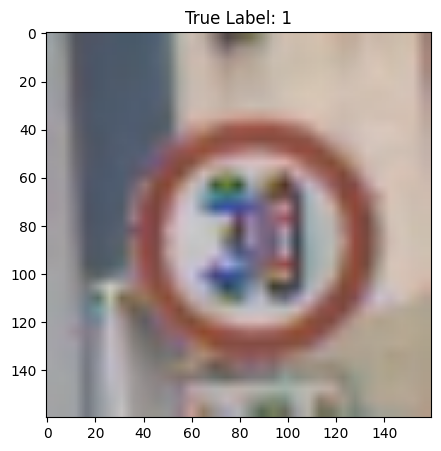

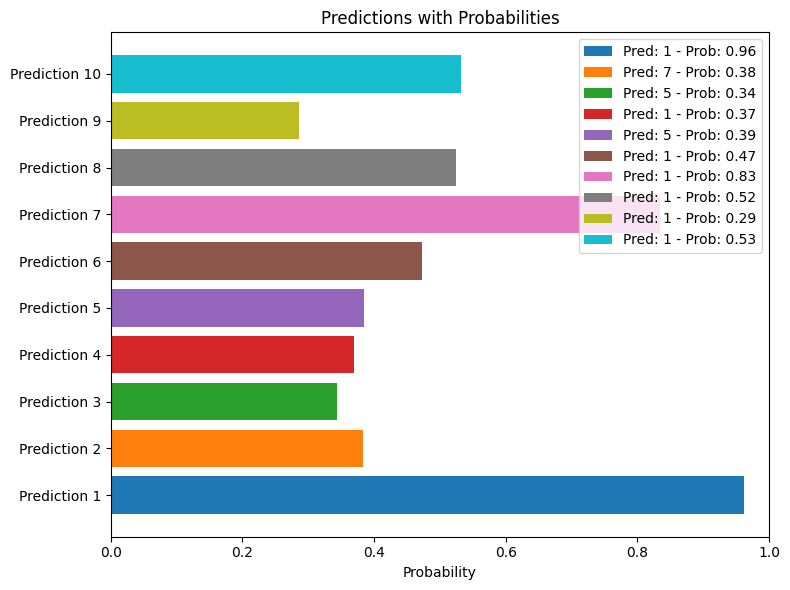

In [201]:
# Function to get predictions by sampling from the posterior
def sample_posterior(model, image, num_samples, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []  # List to store predictions

    with torch.no_grad():
        # Sample predictions for the provided image
        for _ in range(num_samples):
            output = model(image)  # Forward pass
            probs = torch.nn.functional.softmax(output, dim=-1)  # Get probabilities
            predictions.append(probs[0].cpu())  # Store probabilities for the first image

    return torch.stack(predictions)  # Stack predictions into a tensor

# Function to visualize predictions for a single image
def visualize_single_image_predictions(image, label, predictions):
    image = denormalize(image)  # Denormalize before displaying
    plt.figure(figsize=(5, 5))
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())  # Assuming images are in [C, H, W] format
    plt.title(f'True Label: {label}')

    # Display predictions with probabilities
    plt.figure(figsize=(8, 6))
    for i, probs in enumerate(predictions):
        predicted_class = torch.argmax(probs).item()
        probability = probs[predicted_class].item()
        plt.barh(i, probability, label=f'Pred: {predicted_class} - Prob: {probability:.2f}')

    plt.xlabel('Probability')
    plt.yticks(range(len(predictions)), [f'Prediction {j+1}' for j in range(len(predictions))])
    plt.title('Predictions with Probabilities')
    plt.xlim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Set the number of samples
num_samples = 10

# Get predictions for a single image from the validation set
with torch.no_grad():
    for images, labels in val_dl:
        images, labels = images.to(device), labels.to(device)

        # Sample predictions for one image by adding a batch dimension
        predictions = sample_posterior(bnn_model, images[0].unsqueeze(0), num_samples, device)

        # Visualize the predictions for the single image
        visualize_single_image_predictions(images[0], labels[0], predictions)
        break  # Show only one image


# Adversiaral attack and/or out of distribution data

We in this section want to compare robustness of our CNN and bayesian our CNN against adversiaral attacks and/or out of distribtuion (OOD) data.

## Out of distribution data

Here we want to check what happens if we give our model for example a sign it hasn't seen before.

We want in the ideal case our CNN model to give same prob for each class, since it should reflect the uncertainty it has.

For the bayesian CNN we also want it for each sample of the posterior to give many different classes since it should be unsure about what this sign is.

## Adversiaral attack

Here we want to see how robust our models are if we make some
changes to the signs (think a damaged sign).